In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

#As many features/ data as possible, limit to specific to state, change every state to specific timescale, day 0 for new york
#day for 0 for Arizona, use stacking, different states of US, first data point, death per people, y axis new cases per capita

In [1]:
cd '/Users/jbud/Desktop/Galvanize/repos/Capstone-2'

/Users/jbud/Desktop/Galvanize/repos/Capstone-2


In [39]:
# %load src/main.py
'''
Ideas : 

questions:

A little concerned about the data - seem to show negative trend in scatter matrix - should i trim off data with very little/ no new cases?
Implement ARIMA?
Use data from countries that have covid contained (Have data for south Korea - use that data to help train the data?)

Use just CO data or specialize in specific region of US?

#Need to replace first data point for each state with 0

'''
import pandas as pd
import datetime
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

class reg_model(object):
    def __init__(self, X, y, log_trans_y = False):
        self.X = X
        self.y = y if log_trans_y == False else np.log(y + 1)
        self.log_trans_y = log_trans_y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y)
        self.error_metric = None

    def lin_reg(self):
        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def log_reg(self):
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def ridge_reg(self, alpha= 0.5):
        def optimize_alpha(alpha_list):
            pass
        self.model = Ridge(alpha = alpha)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rss'

    def rand_forest(self, n_trees = 50):
        '''
        Upon inspection of the model over time, the number of new cases shows a period of exponential growth, then linear growth where the new cases levels off. Then a random forest model can be applied. A Y-transform should be applied on the data. 
        '''
        if n_trees == 'optimize':
            max_trees = 100
            n = np.arange(1, max_trees + 1, 1)
            error = []
            for each in n:
                self.model = RandomForestRegressor(n_estimators = each)
                self.model.fit(self.X_train, self.y_train)
                self.error_metric = 'rmse'
                error.append(self.evaluate_model())
            #plt.plot(n, error)
            n_trees = n[error.index(min(error))]
        self.model = RandomForestRegressor(n_estimators = n_trees)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def evaluate_model(self):
        self.y_hat = self.model.predict(self.X_test)
        self.predicted_vals_df = pd.DataFrame(self.y_test)
        self.predicted_vals_df['days_elapsed'] = self.X_test['days_elapsed']
        self.predicted_vals_df['y_hat'] = self.y_hat
        self.predicted_vals_df.sort_index(inplace = True)
        if self.error_metric == 'rmse':
            rmse = np.sqrt(mean_squared_error(self.y_test, self.y_hat))
            return rmse
        elif self.error_metric == 'rss':
            rss = np.mean((self.y_test - self.y_hat)**2)
            return rss
    
    def forecast_vals(self, to_forecast_df):
        self.forecasted = self.model.predict(to_forecast_df)
        return self.forecasted
    
    def plot_model(self):
        fig, ax = plt.subplots(figsize = (10,6))
        if self.log_trans_y == True:
            self.y_test = np.e ** self.predicted_vals_df['New_Cases']
            self.y_hat = np.e ** self.predicted_vals_df['y_hat']
        ax.plot(self.predicted_vals_df.loc[:,0], self.y_test, c = 'blue', label = "Test Data")
        ax.plot(self.predicted_vals_df.iloc[:,0], self.y_hat, c = 'green', label = 'Predicted Data')
        ax.legend()
        fig.show()

def clean_data(df, datetime_col = None):
    clean_df = df.copy()
    if datetime_col != None:
        clean_df[datetime_col] = pd.to_datetime(clean_df[datetime_col])
    return clean_df

def replace_initial_values(df, col_change, val_col):
    '''
    When creating new feature columns using difference of existing columns, this function will replace the initial value in val_col of col_change with a 0.
    '''
    prev = None
    for i, st in zip(df.index, df[col_change]):
        if st != prev:
            df.loc[i, val_col] = 0
        else:
            continue
        prev = st
    return df

def load_and_clean_data():
    '''
    Sets up and generates dataframe for analysis
    '''

    #Import and clean covid data (Cases in 2020)
    covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
    covid_df = clean_data(covid_raw_df, datetime_col='date')
    covid_df.sort_values(['state', 'date'], inplace = True)
    covid_df['New_Cases'] = covid_df['cases'].diff()

    covid_df = replace_initial_values(covid_df, 'state', 'New_Cases')
    '''
    Mobility Data - From Google
    #The baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020
    https://www.google.com/covid19/mobility/index.html?hl=en
    '''
    
    mobility_raw_df = pd.read_csv(
        'data/Global_Mobility_Report.csv', low_memory=False)
    US_mobility_raw_df = mobility_raw_df[(mobility_raw_df['country_region'] == 'United States') & (
        mobility_raw_df['sub_region_1'].isnull() == False) & (mobility_raw_df['sub_region_2'].isnull() == True)]
    mobility_df = clean_data(US_mobility_raw_df, datetime_col='date')
    mobility_df.reset_index(inplace=True)
    mobility_df.drop(['index', 'country_region_code',
                      'country_region', 'sub_region_2'], axis=1, inplace=True)
    mobility_df.rename(columns=lambda x: x.replace(
        '_percent_change_from_baseline', ''), inplace=True)
    mobility_df.rename(columns = {'sub_region_1' : 'state'},inplace = True)
    num_cols = ['retail_and_recreation', 'grocery_and_pharmacy',
                'parks', 'transit_stations', 'workplaces', 'residential']
    mobility_df[num_cols] = mobility_df[num_cols].apply(pd.to_numeric)

    #Convert to percent of normal
    mobility_df[num_cols] = mobility_df[num_cols].apply(lambda x: (x + 100)/100)
    states = list(set(mobility_df['state']))
    '''
    Transp data - From Apple
    The CSV file and charts on this site show a relative volume of directions requests per country/region, sub-region or city compared to a baseline volume on January 13th, 2020. We define our day as midnight-to-midnight, Pacific time.
    https://www.apple.com/covid19/mobility 
    '''
    transp_raw_df = pd.read_csv('data/applemobilitytrends-2020-05-09.csv')
    transp_df = transp_raw_df[(transp_raw_df['geo_type'] == 'sub-region') & (transp_raw_df['region'].isin(states))].copy()
    #Driving is only available transportation type data available for statewide data
    transp_df.drop(['geo_type', 'alternative_name', 'transportation_type'],
                   axis=1, inplace=True)
    transp_df.set_index('region', inplace=True)
    transp_df = (transp_df.T) / 100  # Convert to percentage of normal
    transp_df.reset_index(inplace=True)
    transp_df.rename(columns={'index': 'date'}, inplace=True)
    transp_df['date'] = pd.to_datetime(transp_df['date'])
    transp_df = transp_df.melt(id_vars=["date"])
    transp_df.rename(columns={'region': 'state'}, inplace = True)

    mobility_df = mobility_df.merge(transp_df, how='inner', on=['date', 'state'])
    covid_df = mobility_df.merge(covid_df, how='inner', on=['date', 'state'])
    covid_df.rename(columns={'value': 'driving'}, inplace=True)
    covid_df.drop(['cases', 'deaths', 'fips'], axis=1, inplace=True)
    
    #Converts date into days elapsed since outbreak- some functions don't work with datetime objects
    #February 15th is earliest data
    min_date = datetime.datetime(2020, 2, 15)
    covid_df['date'] = covid_df['date'].apply(
        lambda x: (x.to_pydatetime() - min_date).days)
    dates = covid_df['date']
    covid_df.rename(columns={'date': 'days_elapsed'}, inplace=True)
    return covid_df

def state_plot(state, df):
    fig, axes = plt.subplots(8, 1, figsize=(12, 15))
    for i, ax in enumerate(axes, 2):
        query = df[df['state'] == state]['days_elapsed']
        x = query.values
        y = covid_df.loc[query.index].iloc[:, i]
        ax.plot(x, y)
    fig.show()

if __name__ == '__main__':
    covid_df = load_and_clean_data()
    # y = covid_df.pop('New_Cases')
    # X = covid_df
    # rf_model = reg_model(X, y, log_trans_y = True)
    # rf_model.rand_forest(n_trees = 'optimize')
    # rf_model.evaluate_model()


In [31]:
    # y = covid_df.pop('New_Cases')
    # X = covid_df
    # rf_model = reg_model(X, y, log_trans_y = True)
    # rf_model.rand_forest(n_trees = 'optimize')
    # rf_model.evaluate_model()

In [41]:
y = covid_df[covid_df['state'] == 'New York'].pop('New_Cases')

In [42]:
X = covid_df[covid_df['state'] == 'New York'].iloc[:,1: -1]

In [43]:
rf_model = reg_model(X, y, log_trans_y = True)

In [44]:
rf_model.rand_forest(n_trees = 50)
rf_model.evaluate_model()

0.500560670672764

In [45]:
covid_df

,state,days_elapsed,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving,New_Cases
0,Alabama,27,1.07,1.32,1.26,1.07,0.98,1.00,1.4313,0.0
1,Alabama,28,1.01,1.28,1.55,1.12,1.04,1.00,1.3987,6.0
2,Alabama,29,0.93,1.16,1.16,1.06,0.96,1.02,0.9460,11.0
3,Alabama,30,0.98,1.24,1.22,1.02,0.90,1.04,1.0137,6.0
4,Alabama,31,0.89,1.17,1.25,0.99,0.83,1.07,0.9406,10.0
...,...,...,...,...,...,...,...,...,...,...
3006,Wyoming,73,0.79,1.01,1.23,0.93,0.67,1.05,1.0462,16.0
3007,Wyoming,74,0.82,1.03,1.76,0.97,0.66,1.11,1.1165,8.0
3008,Wyoming,75,0.80,1.01,1.51,0.99,0.65,1.12,1.1903,15.0
3009,Wyoming,76,0.80,1.03,1.50,1.05,0.69,1.12,1.3494,7.0


In [46]:
rf_model.predicted_vals_df

,New_Cases,days_elapsed,y_hat
1848,0.000000,15,1.163685
1854,3.828641,21,2.480854
1866,7.481556,33,7.729786
1870,8.650325,37,8.825204
1872,8.911125,39,8.820077
1873,8.689801,40,8.536032
1875,9.079320,42,8.915533
1876,8.743213,43,8.931735
1881,9.276222,48,9.049997
1885,9.173988,52,9.095540


/Users/jbud/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


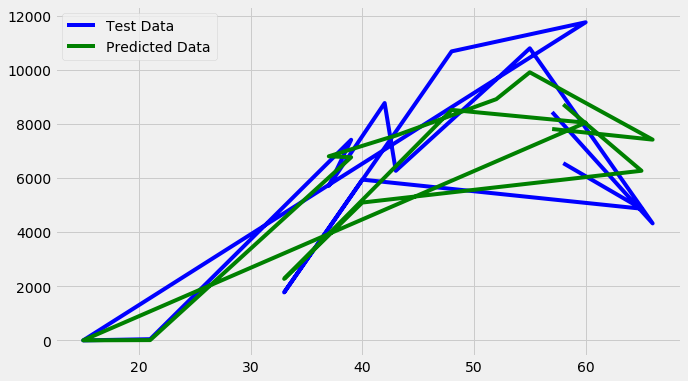

In [47]:
rf_model.plot_model()

In [ ]:
rf_model.X_test.loc[:, 1]

In [ ]:
 rf_model.y_test.shape

In [ ]:
for i in range(60, 100):
    forecast = [[i, 0.49, 0.90, 1.63, 0.46, 0.62, 1.13, 0.7304]]
    print(i, np.e ** rf_model.forecast_vals(forecast)[0])

In [ ]:
fig,ax = plt.subplots(figsize = (20, 20))
ax.plot()

In [ ]:
min_date = datetime.datetime(2020,2,15)

covid_df['date'] = covid_df['date'].apply(lambda x: (x.to_pydatetime() - min_date).days)

In [ ]:
def state_plot(state, df = covid_df):
    fig, axes = plt.subplots(8, 1, figsize = (12,20))
    for i, ax in enumerate(axes, 2):
        query = df[df['state'] == state]['days_elapsed']
        x = query.values
        y = covid_df.loc[query.index].iloc[:,i]
        ax.plot(x, y)
    fig.show()

In [ ]:
state_plot('New York')

In [ ]:
query = covid_df[covid_df['state'] == 'New York']['days_elapsed']

In [ ]:
fig, ax = plt.subplots(figsize = (20, 15))
for state in states:
    query = covid_df[covid_df['state'] == state]['days_elapsed']
    x = query.values
    y = covid_df.loc[query.index].loc[:,'New_Cases']
    ax.plot(x, y, label = state)
# ax.set_xlim(0,30)
# ax.set_ylim(0,200)
ax.legend()

In [ ]:
covid_df.sort_values('New_Cases', ascending = False). head(50)

In [ ]:
state_plot(covid_df, 'Georgia')

In [ ]:
covid_raw_df[covid_raw_df['state'] == 'Georgia'].head(50)

In [ ]:
covid_df[covid_df['state'] == 'New York']['days_elapsed']

In [ ]:
mobility_df = mobility_df.merge(transp_df, how='inner', on=['date', 'state'])

In [ ]:
covid_df = mobility_df.merge(covid_df, how='inner', on=['date', 'state'])

In [ ]:
covid_df.rename(columns = {'value': 'driving'}, inplace = True)

In [ ]:
covid_df

In [ ]:
covid_df.drop(['cases', 'deaths', 'fips'], axis=1, inplace=True)

In [ ]:
covid_df

In [ ]:
#DO NOT ERASE
covid_df = load_and_clean_data()
fig, axes = plt.subplots(2, 1, figsize = (12, 6))
axes[0].plot(covid_df.index, covid_df['cases'])
axes[0].set_ylabel('Total Cases')
axes[1].plot(covid_df.index, covid_df['New_Cases'])
axes[1].set_ylabel('New Cases by day')

In [ ]:
mobility_raw_df = pd.read_csv(
    'data/Global_Mobility_Report.csv', low_memory=False)
US_mobility_raw_df = mobility_raw_df[(mobility_raw_df['country_region'] == 'United States') & (
    mobility_raw_df['sub_region_1'].isnull() == False) & (mobility_raw_df['sub_region_2'].isnull() == True)]
mobility_df = clean_data(US_mobility_raw_df, datetime_col='date')
mobility_df.reset_index(inplace=True)
mobility_df.drop(['index', 'country_region_code',
                  'country_region', 'sub_region_2'], axis=1, inplace=True)
mobility_df.rename(columns=lambda x: x.replace(
    '_percent_change_from_baseline', ''), inplace=True)
mobility_df.rename(columns = {'sub_region_1' : 'state'},inplace = True)
num_cols = ['retail_and_recreation', 'grocery_and_pharmacy',
            'parks', 'transit_stations', 'workplaces', 'residential']
mobility_df[num_cols] = mobility_df[num_cols].apply(pd.to_numeric)

In [ ]:
mobility_df

In [ ]:
mobility_df[num_cols] = mobility_df[num_cols].apply(lambda x: (x + 100)/100)
states = list(set(mobility_df['state']))

In [ ]:
transp_raw_df = pd.read_csv('data/applemobilitytrends-2020-05-09.csv')
transp_df = transp_raw_df[(transp_raw_df['geo_type'] == 'sub-region') & (transp_raw_df['region'].isin(states))].copy()

In [ ]:
transp_df

In [ ]:
transp_raw_df = pd.read_csv('data/applemobilitytrends-2020-05-09.csv')
transp_df = transp_raw_df[(transp_raw_df['geo_type'] == 'sub-region') & (transp_raw_df['region'].isin(states))].copy()
#Driving is only available transportation type data available for statewide data
transp_df.drop(['geo_type', 'alternative_name', 'transportation_type'],
               axis=1, inplace=True)
transp_df.set_index('region', inplace=True)
transp_df = (transp_df.T) / 100  # Convert to percentage of normal
transp_df.reset_index(inplace=True)
transp_df.rename(columns={'index': 'date'}, inplace=True)
transp_df['date'] = pd.to_datetime(transp_df['date'])

In [ ]:
np.e ** (rf_model.predicted_vals_df)

In [ ]:
covid_df = load_and_clean_data()
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(rf_model.predicted_vals_df.index,rf_model.predicted_vals_df['New_Cases'], label = 'Test')
ax.plot(rf_model.predicted_vals_df.index, rf_model.predicted_vals_df['y_hat'], label = 'Predicted') #Random forest linear regression on log transform Y
ax.legend()

In [ ]:
covid_df

In [ ]:
for i in range(40, 100):
    forecast = [[i,0.1, 0.1, 0.1, 0.1, 0.1, 1.8, 1, 0.2811, 0.7129]]
    print(i, np.e ** rf_model.forecast_vals(forecast)[0])

In [ ]:
from pandas.plotting import scatter_matrix
import seaborn as sns; sns.set(style="ticks", color_codes=True)

In [ ]:
fix, axes = plt.subplots(9, 1, figsize = (15,25))
for ax, col in zip(axes, covid_df.columns[1:]):
    ax.plot(covid_df[col])
    ax.set_ylabel(col)
    plt.tight_layout()

In [ ]:
covid_df.info()

In [ ]:
covid_df['New_Cases'] = y

In [ ]:
scatter_matrix(covid_df, figsize = (20, 20))

In [ ]:
unemployment_df = pd.read_csv('LNS14000024.csv', index_col = 0)
unemployment_df.head()
unemployment_df.index = pd.to_datetime(unemployment_df.index)

In [ ]:
plt.plot(unemployment_df)

In [ ]:
plt.style.use('ggplot')
plt.plot(covid_df['New_Cases'])
plt.xticks(rotation = 90)
plt.title('New Cases of COVID-19')
plt.savefig('Covid-19 New')

In [ ]:
cd '/Users/jbud/Desktop/Galvanize/repos/Capstone-2'

In [ ]:
'''
If we use number of cases as the target variable:

'''


import pandas as pd
import datetime
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

class reg_model(object):
    def __init__(self, X, y, log_trans_y = False):
        self.X = X
        self.y = y if log_trans_y == False else np.log(y + 1)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y)
        self.error_metric = None

    def lin_reg(self):
        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def log_reg(self):
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def ridge_reg(self, alpha= 0.5):
        def optimize_alpha(alpha_list):
            pass
        self.model = Ridge(alpha = alpha)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rss'

    def rand_forest(self, n_trees = 50):
        '''
        Upon inspection of the model over time, the number of new cases shows a period of exponential growth, then linear growth where the new cases levels off. Then a random forest model can be applied. A Y-transform is applied on the data. 
        '''
        if n_trees == 'optimize':
            max_trees = 100
            n = np.arange(1, max_trees + 1, 1)
            error = []
            for each in n:
                self.model = RandomForestRegressor(n_estimators = each)
                self.model.fit(self.X_train, self.y_train)
                self.error_metric = 'rmse'
                error.append(self.evaluate_model())
            #plt.plot(n, error)
            n_trees = n[error.index(min(error))]
        self.model = RandomForestRegressor(n_estimators = n_trees)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def evaluate_model(self):
        self.y_hat = self.model.predict(self.X_test)
        self.predicted_vals_df = pd.DataFrame(self.y_test)
        self.predicted_vals_df['y_hat'] = self.y_hat
        self.predicted_vals_df.sort_index(inplace = True)
        if self.error_metric == 'rmse':
            rmse = np.sqrt(mean_squared_error(self.y_test, self.y_hat))
            return rmse
        elif self.error_metric == 'rss':
            rss = np.mean((self.y_test - self.y_hat)**2)
            return rss
    
    def forecast_vals(self, to_forecast_df):
        self.forecasted = self.model.predict(to_forecast_df)
        return self.forecasted
    
    def plot_model(self):
        fig, ax = plt.subplots(figsize = (10,6))
        if self.X_test.iloc[:, 0].shape != self.y_test.shape:
            self.X_test = self.X_test.loc[:,0]
        ax.scatter(self.X_test, self.y_test, c = 'blue', label = "Test Data")
        ax.scatter(self.X_test, self.y_hat, c = 'green', label = 'Predicted Data')
        ax.legend()
        fig.show()

def clean_data(df, datetime_col = None):
    clean_df = df.copy()
    if datetime_col != None:
        clean_df[datetime_col] = pd.to_datetime(clean_df[datetime_col])
    return clean_df

def calc_row_diff(df, colname = 'cases', added_colname = 'New_Cases'):
    '''
    Input: Pandas DataFrame, String of column names
    Output: Dataframe with added column calculating the difference in each row of colname
    '''
    prev = df.iloc[0][colname]
    new = [prev]
    for each in df[colname][1:]:
        new.append(each - prev)
        prev = each
    df[added_colname] = new
    return df

def load_and_clean_data():
    '''
    Sets up and generates dataframe for analysis
    '''

    #Import and clean covid data (Cases in 2020)
    covid_raw_df = pd.read_csv('data/covid-19-data/us.csv')
    covid_df = clean_data(covid_raw_df, datetime_col='date')
    covid_df = calc_row_diff(covid_df)

    # To get daily death and ratio:
    # covid_df = calc_row_diff(covid_df, colname='deaths',
    #                          added_colname='daily_death')
    # covid_df['death/case_ratio'] = covid_df['daily_death'] / \
    #     covid_df['New_Cases']
    # covid_df['death/case_ratio'] = covid_df['death/case_ratio'].fillna(0)

    #Begin loading features that may have something to do with the fluctuation of the virus

    '''
    Mobility Data - From Google
    #The baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020
    '''

    mobility_raw_df = pd.read_csv(
        'data/Global_Mobility_Report.csv', low_memory=False)
    mobility_raw_df.fillna('None', inplace=True)
    US_mobility_raw_df = mobility_raw_df[(mobility_raw_df['country_region'] == 'United States') & (
        mobility_raw_df['sub_region_1'] == 'None')]
    mobility_df = clean_data(US_mobility_raw_df, datetime_col='date')
    mobility_df.reset_index(inplace=True)
    mobility_df.drop(['index', 'country_region_code',
                      'country_region', 'sub_region_1', 'sub_region_2'], axis=1, inplace=True)
    mobility_df.rename(columns=lambda x: x.replace(
        '_percent_change_from_baseline', ''), inplace=True)
    num_cols = ['retail_and_recreation', 'grocery_and_pharmacy',
                'parks', 'transit_stations', 'workplaces', 'residential']
    mobility_df[num_cols] = mobility_df[num_cols].apply(pd.to_numeric)

    #Convert to percent of normal
    mobility_df.iloc[:, 1:] = mobility_df.iloc[:,
                                               1:].apply(lambda x: (x + 100)/100)

    '''
    Transp data - From Apple
    The CSV file and charts on this site show a relative volume of directions requests per country/region, sub-region or city compared to a baseline volume on January 13th, 2020. We define our day as midnight-to-midnight, Pacific time.
    '''
    transp_raw_df = pd.read_csv('data/applemobilitytrends-2020-05-09.csv')
    transp_df = transp_raw_df[(
        transp_raw_df['region'] == 'United States')].copy()
    transp_df.drop(['geo_type', 'region', 'alternative_name'],
                   axis=1, inplace=True)
    transp_df.set_index('transportation_type', inplace=True)
    transp_df = (transp_df.T) / 100  # Convert to percentage of normal
    transp_df.columns = ['driving', 'transit', 'walking']
    transp_df.reset_index(inplace=True)
    transp_df.rename(columns={'index': 'date'}, inplace=True)
    transp_df['date'] = pd.to_datetime(transp_df['date'])

    mobility_df = mobility_df.merge(transp_df, how='inner', on='date')
    covid_df = mobility_df.merge(covid_df, how='inner', on='date')
    covid_df.drop(['deaths', 'New_Cases'], axis=1, inplace=True)
    
    #Converts date into days elapsed since outbreak- some functions don't work with datetime objects
    #Days elapsed is since February 15th
    dates = covid_df['date']
    covid_df['date'] = covid_df.index
    covid_df.rename(columns={'date': 'days_elapsed'}, inplace=True)
    return covid_df

if __name__ == '__main__':
    covid_df = load_and_clean_data()
    y = covid_df.pop('cases')
    X = covid_df
    # ridge_model = reg_model(X, y)
    # ridge_model.ridge_reg()
    # ridge_model.evaluate_model()
    rf_model = reg_model(X, y, log_trans_y = True)
    rf_model.rand_forest(n_trees = 'optimize')
    rf_model.evaluate_model()


    # log_reg_model = reg_model(np.array(covid_df.index).reshape(-1, 1),
    #                 covid_df['New_Cases'])
    # log_reg_model.log_reg()
    # print(log_reg_model.evaluate_model())
    # log_reg_model.plot_model()


In [ ]:
covid_df['target'] = y

In [ ]:
covid_df

In [ ]:
for i in range(78, 100):
    forecast = [[i, 1, 1, 1, 1, 1, 1, 0.8434, 0.2811, 0.7129]]
    print(i, np.e ** rf_model.forecast_vals(forecast)[0])

In [ ]:
#Full Dataset
covid_df = load_and_clean_data()
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(rf_model.predicted_vals_df.index,rf_model.predicted_vals_df['cases'], label = 'Test')
ax.plot(rf_model.predicted_vals_df.index, rf_model.predicted_vals_df['y_hat'], label = 'Predicted') #Random forest linear regression on log transform Y
ax.legend()

In [ ]:
plt.plot(np.log(covid_raw_df['cases']))

In [ ]:
def clean_data(df, datetime_col = None):
    clean_df = df.copy()
    if datetime_col != None:
        clean_df[datetime_col] = pd.to_datetime(clean_df[datetime_col])
    return clean_df

In [ ]:
covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
covid_df = clean_data(covid_raw_df, datetime_col='date')
covid_df.sort_values(['state', 'date'], inplace = True)
covid_df['New_Cases'] = covid_df['cases'].diff()

In [ ]:
covid_df

In [ ]:
def replace_initial_values(df, col_change, val_col):
    prev = None
    for i, st in zip(df.index, df[col_change]):
        if st != prev:
            df.loc[i, val_col] = 0
        else:
            continue
        prev = st
    return df
covid_df = replace_initial_values(covid_df, 'state', 'New_Cases')

In [ ]:
covid_df

In [ ]:
prev = None
for i, st in zip(covid_df.index, covid_df['state']):
    print(i, st, prev)
    if st != prev:
        covid_df.loc[i, 'New_Cases'] = 0
    else:
        continue
    prev = st

In [ ]:
covid_df

In [ ]:
covid_df[covid_df['state'] == 'New York']